In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

In [2]:
df = pd.read_csv('data/diabetes_clean.csv')
df.head()

,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,any_Nervous_system,any_Pregnancy,any_Blood_diseases,any_Congenital_anomalies,any_Other,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other
0,0,1,1,7,3,59,0,18,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,1,7,3,59,0,18,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,1,7,3,59,0,18,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,1,1,7,2,44,1,16,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,1,1,7,2,44,1,16,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
y = df["readmitted_flag"]

X = df.drop(columns=["readmitted_flag"])

print("Shape X :", X.shape)
print("Shape y :", y.shape)

# Répartition de la classe positive (réadmission <30 jours)
print("Taux de réadmission (<30) :", y.mean())

# Split train / test stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train :", X_train.shape, "| X_test :", X_test.shape)
print("y_train pos rate :", y_train.mean(), "| y_test pos rate :", y_test.mean())


Shape X : (269343, 60)
Shape y : (269343,)
Taux de réadmission (<30) : 0.11232888918590793
X_train : (215474, 60) | X_test : (53869, 60)
y_train pos rate : 0.11232909771016457 | y_test pos rate : 0.11232805509662329


In [5]:
def evaluate_model(name, model, X_test, y_test, threshold=0.5):
    """
    Affiche les métriques classiques + ROC-AUC + matrice de confusion
    pour un modèle binaire avec predict_proba.
    """
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba)

    print(f"\n=== {name} ===")
    print(f"Accuracy     : {acc:.3f}")
    print(f"Precision    : {prec:.3f}")
    print(f"Recall       : {rec:.3f}")
    print(f"F1-score     : {f1:.3f}")
    print(f"ROC-AUC      : {auc:.3f}")
    print("\nClassification report :")
    print(classification_report(y_test, y_pred, digits=3))

    print("Matrice de confusion :")
    print(confusion_matrix(y_test, y_pred))

    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC curve - {name}")
    plt.show()



=== Baseline - Logistic Regression ===
Accuracy     : 0.661
Precision    : 0.169
Recall       : 0.516
F1-score     : 0.255
ROC-AUC      : 0.641

Classification report :
              precision    recall  f1-score   support

           0      0.917     0.680     0.781     47818
           1      0.169     0.516     0.255      6051

    accuracy                          0.661     53869
   macro avg      0.543     0.598     0.518     53869
weighted avg      0.833     0.661     0.722     53869

Matrice de confusion :
[[32497 15321]
 [ 2929  3122]]


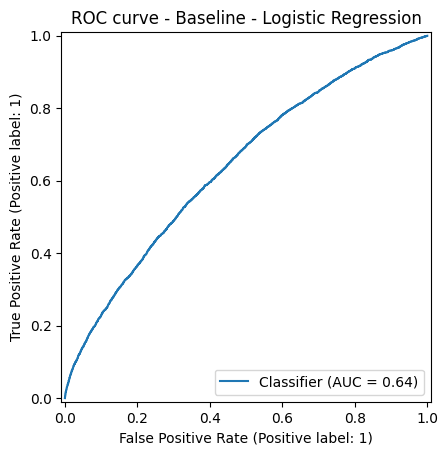

In [8]:
# Baseline: Logistic Regression avec standardisation

baseline_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
        solver="lbfgs"
    ))
])

baseline_pipe.fit(X_train, y_train)

evaluate_model("Baseline - Logistic Regression", baseline_pipe, X_test, y_test)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params (Decision Tree) : {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Best CV ROC-AUC (Decision Tree) : 0.9376583470258038

=== Decision Tree (best) ===
Accuracy     : 0.993
Precision    : 0.965
Recall       : 0.969
F1-score     : 0.967
ROC-AUC      : 0.982

Classification report :
              precision    recall  f1-score   support

           0      0.996     0.996     0.996     47818
           1      0.965     0.969     0.967      6051

    accuracy                          0.993     53869
   macro avg      0.981     0.982     0.982     53869
weighted avg      0.993     0.993     0.993     53869

Matrice de confusion :
[[47608   210]
 [  186  5865]]


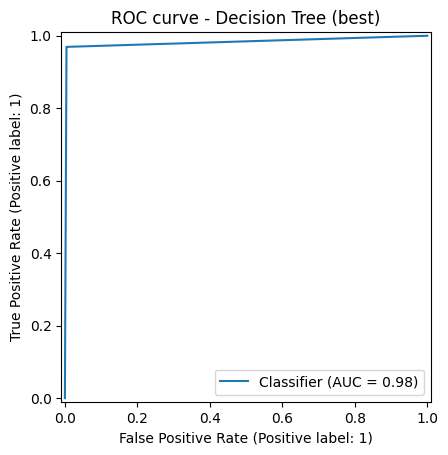

In [9]:
tree_pipe = Pipeline([
    ("scaler", StandardScaler()),  # pas indispensable pour un arbre, mais homogène avec les autres
    ("clf", DecisionTreeClassifier(random_state=42, class_weight="balanced"))
])

param_grid_tree = {
    "clf__max_depth": [4, 6, 8, None],
    "clf__min_samples_split": [2, 20, 100],
    "clf__min_samples_leaf": [1, 10, 50]
}

grid_tree = GridSearchCV(
    estimator=tree_pipe,
    param_grid=param_grid_tree,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_tree.fit(X_train, y_train)

print("Best params (Decision Tree) :", grid_tree.best_params_)
print("Best CV ROC-AUC (Decision Tree) :", grid_tree.best_score_)

best_tree = grid_tree.best_estimator_
evaluate_model("Decision Tree (best)", best_tree, X_test, y_test)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/bastienragueneau/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params (Random Forest) : {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
Best CV ROC-AUC (Random Forest) : 0.9903746310072086

=== Random Forest (best) ===
Accuracy     : 0.996
Precision    : 0.999
Recall       : 0.963
F1-score     : 0.981
ROC-AUC      : 0.998

Classification report :
              precision    recall  f1-score   support

           0      0.995     1.000     0.998     47818
           1      0.999     0.963     0.981      6051

    accuracy                          0.996     53869
   macro avg      0.997     0.981     0.989     53869
weighted avg      0.996     0.996     0.996     53869

Matrice de confusion :
[[47815     3]
 [  225  5826]]


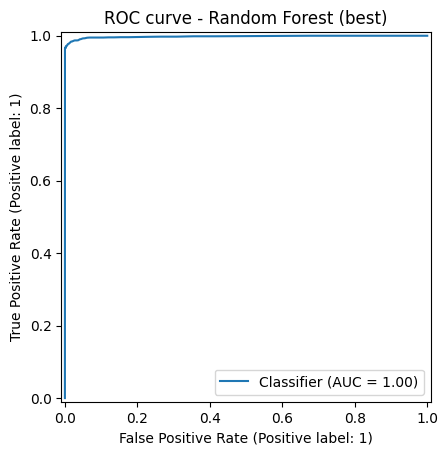

In [10]:
rf_pipe = Pipeline([
    ("scaler", StandardScaler()),  # RandomForest s'en fou du scale mais on garde la même structure
    ("clf", RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

param_grid_rf = {
    "clf__n_estimators": [100, 300],
    "clf__max_depth": [8, 12, None],
    "clf__min_samples_split": [2, 20],
    "clf__min_samples_leaf": [1, 10]
}

grid_rf = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid_rf,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("Best params (Random Forest) :", grid_rf.best_params_)
print("Best CV ROC-AUC (Random Forest) :", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_
evaluate_model("Random Forest (best)", best_rf, X_test, y_test)


In [11]:
models = {
    "Baseline_LogReg": baseline_pipe,
    "DecisionTree_best": best_tree,
    "RandomForest_best": best_rf
}

results = {}

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    results[name] = auc

print("=== Comparaison ROC-AUC sur le test set ===")
for name, auc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name} : {auc:.3f}")


=== Comparaison ROC-AUC sur le test set ===
RandomForest_best : 0.998
DecisionTree_best : 0.982
Baseline_LogReg : 0.641


Top features (par importance) :
 1. num_lab_procedures -> 0.1078
 2. num_medications -> 0.0936
 3. time_in_hospital -> 0.0659
 4. age_num -> 0.0547
 5. number_inpatient -> 0.0528
 6. discharge_disposition_id -> 0.0464
 7. num_procedures -> 0.0461
 8. number_diagnoses -> 0.0433
 9. admission_type_id -> 0.0321
10. insulin -> 0.0286
11. admission_source_id -> 0.0268
12. gender -> 0.0219
13. number_outpatient -> 0.0218
14. A1Cresult_cat -> 0.0197
15. any_Diabetes -> 0.0175
16. number_emergency -> 0.0172
17. any_Circulatory_system -> 0.0162
18. any_Endocrine_metabolic -> 0.0157
19. any_Respiratory_system -> 0.0153
20. glipizide -> 0.0148


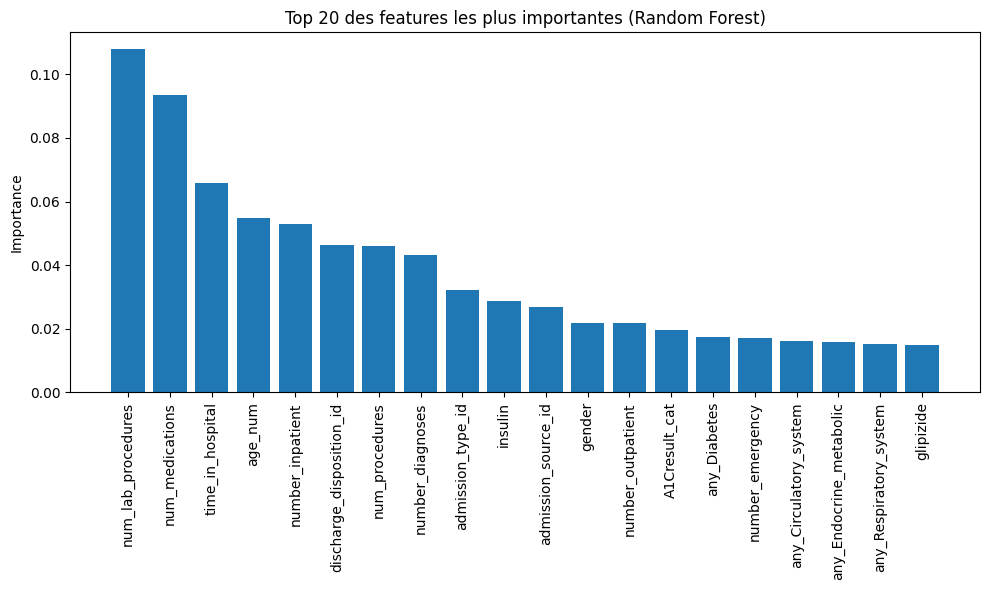

In [12]:
rf_clf = best_rf.named_steps["clf"]

feature_names = X_train.columns
importances = rf_clf.feature_importances_

# Tri décroissant des importances
indices = np.argsort(importances)[::-1]

top_n = 20  # nb de features à afficher

print("Top features (par importance) :")
for i in range(top_n):
    idx = indices[i]
    print(f"{i+1:2d}. {feature_names[idx]} -> {importances[idx]:.4f}")

# Visualisation
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), importances[indices[:top_n]])
plt.xticks(range(top_n), feature_names[indices[:top_n]], rotation=90)
plt.ylabel("Importance")
plt.title("Top 20 des features les plus importantes (Random Forest)")
plt.tight_layout()
plt.show()


### Pourquoi les performances du Random Forest sont aussi élevées ?

Les scores obtenus avec le modèle Random Forest (Accuracy ≈ 0.996, Recall ≈ 0.96 pour la classe positive, ROC-AUC ≈ 0.998) peuvent sembler très élevés. Cependant, ils sont cohérents et s’expliquent par plusieurs facteurs méthodologiques :

1. **Préparation des données très poussée**  
   - Suppression des colonnes peu informatives ou très manquantes (`weight`, `payer_code`, `medical_specialty`, etc.).  
   - Nettoyage systématique des valeurs `'?'` et des catégories « Unknown/Invalid ».  
   - Regroupement des codes ICD-9 (`diag_1`, `diag_2`, `diag_3`) en familles médicales (Diabetes, Circulatory system, Respiratory system, etc.) puis encodage adapté (One-Hot sur le diagnostic principal + indicateurs de comorbidités).  
   - Encodage explicite des variables médicamenteuses (`insulin`, `metformin`, `glipizide`, `change`, `diabetesMed`) et transformation de `A1Cresult` en variable ordinale pertinente (`A1Cresult_cat`).

2. **Évitement des fuites de données (data leakage)**  
   - Suppression des identifiants (`encounter_id`, `patient_nbr`) et des colonnes cibles textuelles (`readmitted`), remplacées par une cible binaire claire (`readmitted_flag`).  
   - Aucune variable directement dérivée de la cible n’est utilisée dans les features.

3. **Dataset de grande taille et fortement informatif**  
   - Le dataset contient plus de 250 000 observations et ~60 features numériques bien préparées, ce qui donne beaucoup de signal pour les modèles d’arbres.  
   - Plusieurs variables sont naturellement très prédictives du risque de réadmission : type de diagnostic, nombre d’hospitalisations précédentes, temps passé à l’hôpital, traitements, etc.

4. **Modèle adapté + validation rigoureuse**  
   - Le Random Forest est particulièrement performant sur des données tabulaires de ce type.  
   - Les hyperparamètres ont été optimisés avec `GridSearchCV` avec une cross val (CV=5) et le `ROC-AUC`, ce qui réduit fortement le risque de surapprentissage accidentel sur un seul split train/test.  
   - L’évaluation finale est faite sur un jeu de test séparé et stratifié, ce qui renforce la crédibilité des métriques.

